# 图像增广

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

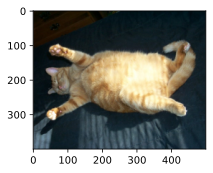

In [4]:
# 导入图片
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

## 常用的图像增广方法

In [5]:
# 在输入图像img上多次运行图像增广方法aug并显示所有结果，便于观察图像增广的效果
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

###  翻转和裁剪

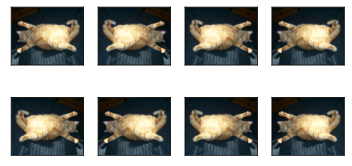

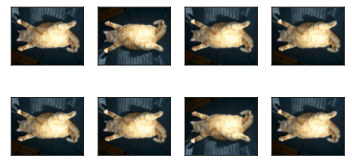

In [6]:
# 水平（左右翻转）
apply(img, torchvision.transforms.RandomHorizontalFlip())
# 垂直（上下翻转）
apply(img, torchvision.transforms.RandomVerticalFlip())

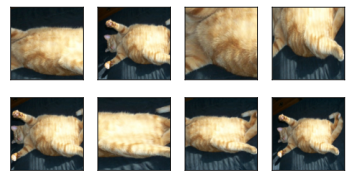

In [7]:
# 随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比为0.5～2，且区域的宽度和高度都被缩放到200像素
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色
改变图像颜色的四个方面：亮度、对比度、饱和度和色调

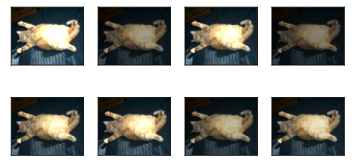

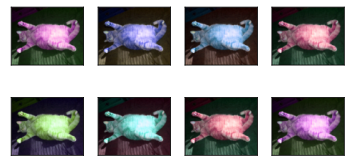

In [8]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

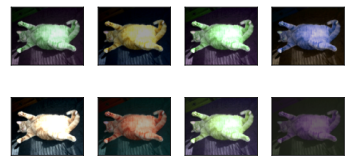

In [9]:
# 同时随机更改图像的亮度、对比度、饱和度和色调
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 结合多种图像增广方法

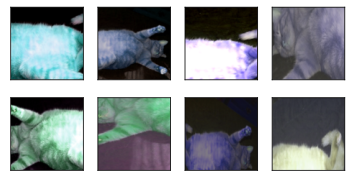

In [10]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), shape_aug, color_aug, ])
apply(img, augs)

## 使用图像增广进行训练

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


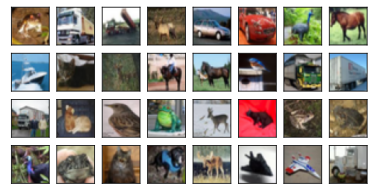

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

通常只对训练样本进行图像增广，且在预测过程中不使用随机操作的图像增广

In [12]:
# 使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [13]:
# 定义一个辅助函数，便于读取图像和应用图像增广
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

## 多GPU训练
**定义一个函数，使用多GPU对模型进行训练和评估**

In [14]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    # nn.DataParallel：用于将模型并行化，以便在多个GPU上进行训练或推理
    # to(devices[0])：将并行化后的模型移动到第一个设备上
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[3],None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

**定义`train_with_data_aug`函数，使用图像增广来训练模型**  
该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用用于训练和评估模型的`train_ch13`函数。

In [15]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbd34cd1040>
Traceback (most recent call last):
  File "/Users/gauvain/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/Users/gauvain/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1445, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/gauvain/anaconda3/envs/d2l/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/gauvain/anaconda3/envs/d2l/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/gauvain/anaconda3/envs/d2l/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/gauvain/anaconda3/envs/d2l/lib/python3.9/selectors.py", line 416, in select
    fd_event_

KeyboardInterrupt: 

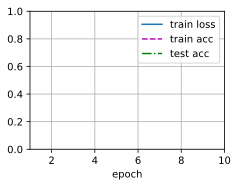

In [17]:
train_with_data_aug(train_augs, test_augs, net)

In [ ]:
# 对比训练集不使用图像增广的效果
train_with_data_aug(test_augs, test_augs, net)

## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。